<a href="https://colab.research.google.com/github/m-xsk/m-xsk/blob/main/StanfordDogsDataset_Augmentationvs_NoAugmentationAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
# Load full datasets
(train_ds_full, test_ds), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Take subset: only 6000 images for training
train_ds = train_ds_full.take(6000)

print(f"Subset training samples: 6000")
print(f"Test samples: {ds_info.splits['test'].num_examples}")
print(f"Number of classes: {ds_info.features['label'].num_classes}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.Q919KF_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.Q919KF_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
Subset training samples: 6000
Test samples: 8580
Number of classes: 120


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64  # Keep bigger batch size for faster training

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


In [6]:
# Pretrained MobileNetV2 base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Function to build model
def build_model(apply_augmentation=False):
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = inputs
    if apply_augmentation:
        x = data_augmentation(x)

    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(120, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create two models
model_no_aug = build_model(apply_augmentation=False)
model_aug = build_model(apply_augmentation=True)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
EPOCHS = 3  # Only 3 epochs to make it fast!

# Model without augmentation
history_no_aug = model_no_aug.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)

# Model with augmentation
history_aug = model_aug.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)


Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 412ms/step - accuracy: 0.2753 - loss: 3.4816 - val_accuracy: 0.6950 - val_loss: 1.2034
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.8011 - loss: 0.8256 - val_accuracy: 0.7372 - val_loss: 0.9368
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.8776 - loss: 0.5253 - val_accuracy: 0.7459 - val_loss: 0.8612
Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 295ms/step - accuracy: 0.2089 - loss: 3.8036 - val_accuracy: 0.6592 - val_loss: 1.4151
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 273ms/step - accuracy: 0.6518 - loss: 1.3731 - val_accuracy: 0.7149 - val_loss: 1.0498
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 337ms/step - accuracy: 0.7238 - loss: 1.0228 - val_accuracy: 0.7347 - val_loss: 0.9323


In [8]:
# Evaluate
test_loss_no_aug, test_acc_no_aug = model_no_aug.evaluate(test_ds)
test_loss_aug, test_acc_aug = model_aug.evaluate(test_ds)

print("\nNo Augmentation - Test Loss:", test_loss_no_aug, ", Test Accuracy:", test_acc_no_aug)
print("With Augmentation - Test Loss:", test_loss_aug, ", Test Accuracy:", test_acc_aug)


135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7482 - loss: 0.8615
135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.7354 - loss: 0.9318

No Augmentation - Test Loss: 0.8612446784973145 , Test Accuracy: 0.745920717716217
With Augmentation - Test Loss: 0.9322656989097595 , Test Accuracy: 0.734731912612915


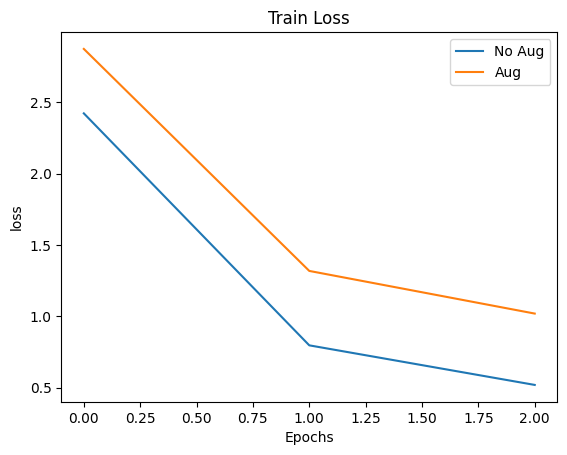

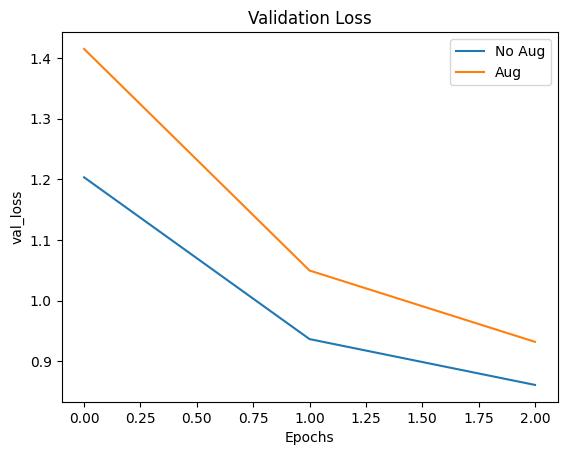

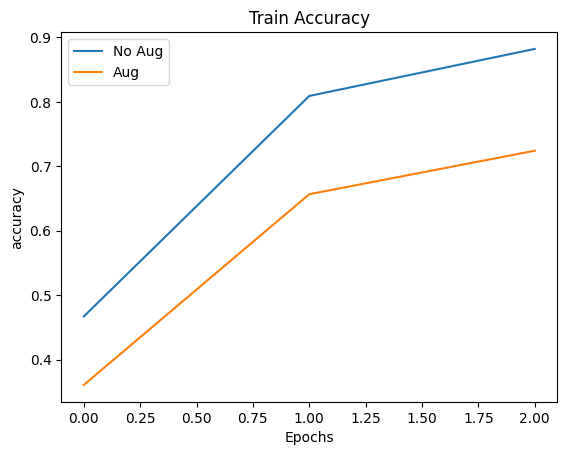

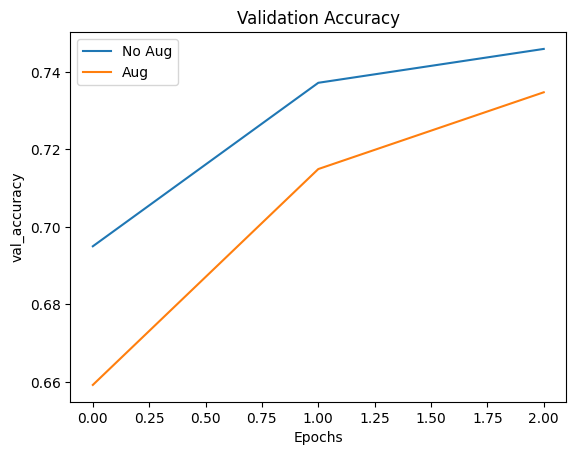

In [9]:
# Helper function to plot
def plot_metrics(history1, history2, metric, title):
    plt.plot(history1.history[metric], label='No Aug')
    plt.plot(history2.history[metric], label='Aug')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# Plot figures
plot_metrics(history_no_aug, history_aug, 'loss', 'Train Loss')
plot_metrics(history_no_aug, history_aug, 'val_loss', 'Validation Loss')
plot_metrics(history_no_aug, history_aug, 'accuracy', 'Train Accuracy')
plot_metrics(history_no_aug, history_aug, 'val_accuracy', 'Validation Accuracy')


In [10]:
# Create table
results = {
    "Model": ["Pretrained_no_aug", "Pretrained_aug"],
    "Train Loss": [
        history_no_aug.history['loss'][-1],
        history_aug.history['loss'][-1]
    ],
    "Train Accuracy": [
        history_no_aug.history['accuracy'][-1],
        history_aug.history['accuracy'][-1]
    ],
    "Validation Loss": [
        history_no_aug.history['val_loss'][-1],
        history_aug.history['val_loss'][-1]
    ],
    "Validation Accuracy": [
        history_no_aug.history['val_accuracy'][-1],
        history_aug.history['val_accuracy'][-1]
    ]
}

df = pd.DataFrame(results)
print(df)


               Model  Train Loss  Train Accuracy  Validation Loss  \
0  Pretrained_no_aug    0.519431        0.882167         0.861245   
1     Pretrained_aug    1.019287        0.724167         0.932266   

   Validation Accuracy  
0             0.745921  
1             0.734732  
